In [ ]:
import os
import glob
import numpy as np
import cv2
import torch
import warnings

In [ ]:
from utils.xyz import gamma, positional_encoder
from utils.nets import Nerf

In [ ]:
vec = torch.rand(10,5)
model = Nerf()
sigma, color = model.forward(vec)

In [ ]:
from utils.dataload import load_data
data, cam_params = load_data('data/nerf_synthetic/lego/')

In [ ]:
from utils.xyz import rays_single_cam

def rays_dataset(samples, cam_params):
	""" Generates rays and camera origins for train test and val sets under diff camera poses""" 
	keys = ['train', 'test', 'val']
	rays_1_cam = rays_single_cam(cam_params)
	rays = {}
	cam_origins = {}
	H, W, f = cam_params
	for k in keys:
		num_images = len(samples[k])
		transf_mats = torch.stack([s['transform'] for s in samples[k]])
		rays_dataset = torch.matmul(transf_mats[:,:3,:3], rays_1_cam)
		cam_origins = transf_mats[:,:3,3:]
		cam_origins = cam_origins.expand(num_images,3,H*W) #Nx3xHW
		rays[k] = torch.cat((cam_origins, rays_dataset),dim=1).permute(1,0,2).reshape(6,-1) # 6xNHW, number of cameras 

	return rays

class RayGenerator:
	def __init__(self, path, on_gpu=False):
		samples, cam_params = load_data(path)
		self.samples = samples
		self.H = cam_params[0]
		self.W = cam_params[1]
		self.f = cam_params[2]
		self.rays_dataset = rays_dataset(self.samples, cam_params)
		
		# self.on_gpu = on_gpu
		# if on_gpu:
		# 	for k in self.cam_origins.keys():
		# 		self.rays_dataset[k] = self.rays_dataset[k].cuda()

	def select(self, mode='train', N=4096):
		""" randomly selects N train/test/val rays
		Args:
			mode: 'train', 'test', 'val'
			N: number of rays to sample 
		Returns:
			rays (torch Tensor): Nx6 
		"""
		data = self.rays_dataset[mode]
		samples = self.samples[mode]
		ray_ids = torch.randint(0, data.size(1), (N,))
		rays = data[:,ray_ids]
		return rays, ray_ids 
		
rays = rays_dataset(data, cam_params)



def sampler(rays_dataset, batch_size):
	""" create a batch of rays from rays_dataset 
	Args:
		rays_dataset (torch tensor): Nx3xHW . N - #cameras, HW - #pixels in image
		batch_size: batch size of rays 
	"""

In [1]:
from utils.dataload import rays_dataset, RayGenerator
from utils.nets import Nerf
import torch

rg = RayGenerator(path='data/nerf_synthetic/lego/')

net = Nerf()
net.load_state_dict(torch.load('models/1665717276.4336596.pth'))

samps = rg.samples['val']


/home/ubuntu/.local/lib/python3.8/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


  0%|          | 0/10 [00:00<?, ?it/s]/home/ubuntu/NeRF_CT/utils/xyz.py:9: UserWarning: input not in range -1,1, check rescaling
  warnings.warn("input not in range -1,1, check rescaling")
100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


torch.Size([640000, 3])
torch.Size([640000])


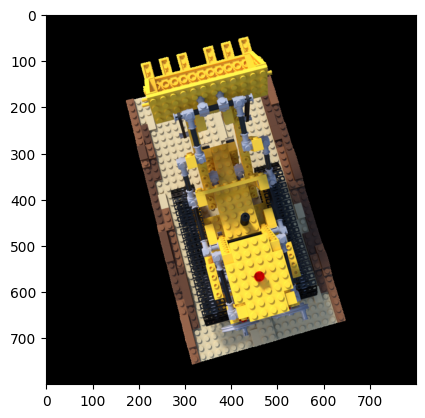

In [10]:
import matplotlib.pyplot as plt
from utils.rendering import render_nerf 
from tqdm import tqdm 

plt.imshow(rg.samples['val'][0]['img'])

NUM_IMG_RAYS = 640000
net = net.cuda()
rays = rg.rays_dataset['val'][:,:NUM_IMG_RAYS].transpose(1,0)

batch_size = 64000

rgbs = [] 
depths = [] 
with torch.no_grad():
	for i in tqdm(range(rays.size(0) // batch_size)):
		inp_rays = rays[i*batch_size:(i+1)*batch_size]
		rgb, depth, _, _, _ = render_nerf(inp_rays.cuda(), net, N=128)
		rgbs.append(rgb)
		depths.append(depth)

rgb = torch.cat(rgbs)
depth = torch.cat(depths)

print(rgb.size())
print(depth.size())



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


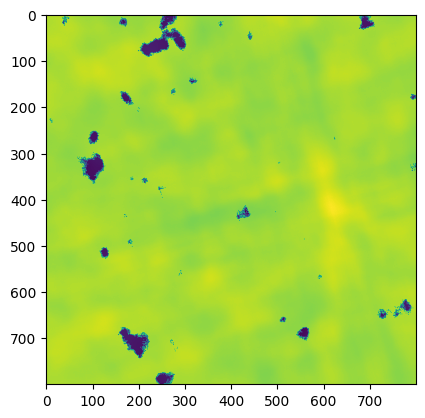

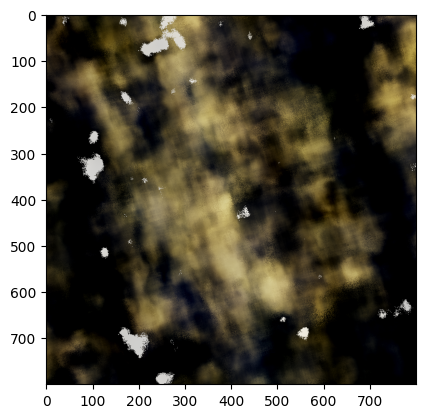

In [18]:
rgb_img = rgb.reshape(800,800,3)

depth_img = depth.reshape(800,800).cpu().numpy()
plt.imshow(depth_img)
plt.figure()
plt.imshow(rgb_img.cpu().numpy())

In [9]:
rays.size(0)

64000000

In [5]:
# rays, ray_ids = rg.select()
# train_imgs = torch.stack([torch.from_numpy(s['img']) for s in rg.samples['train']]).reshape(-1,3).transpose(1,0)


import torch 

N = 4096
ray_ids = torch.randint(0, 16000000, (N,))

print(torch.unique(ray_ids).size())

torch.Size([4095])


In [6]:
torch.randperm(10)

tensor([8, 6, 7, 1, 2, 4, 3, 0, 5, 9])

In [ ]:
def render_nerf(rays, N, tn=2, tf=6):
	""" stratified sampling on a set of rays using Nerf model
	Args:
		rays (torch Tensor): B x 6 
		net (nerf model):
	Returns:
		 out: BxNx4	
	"""
	## input to nerf model BN x 6 
	## Nerf output - BN x 4  --> reshape BxNx4 
	## t sample dims - BxN
	t_bins = torch.linspace(tn,tf,N+1)
	bin_diff = t_bins[1] - t_bins[0] 

	unif_samps = torch.rand(rays.size(0),N)
	ts = bin_diff* unif_samps + t_bins[:-1] # BxN 

	origins = rays[:,:3] # Bx3
	dirs = rays[:,3:]  # Bx3

	disp = dirs.unsqueeze(-1)*ts.unsqueeze(1) # Bx1x3 * BxNx1 = Bx3xN
	locs = origins.unsqueeze(-1) + disp # Bx3x1 + Bx3xN = Bx3xN 
	query_pts = torch.cat((locs, dirs.unsqueeze(-1).expand(-1,-1,N)),dim=1)
	return query_pts 

query_pts = render_nerf(rays, N=100)

query_pts[0][:,:8]

In [ ]:
def volume_render(ts, nerf_outs):
	""" computes color, depth and alphas along rays using NeRF outputs (section 4)
	Args:
		ts (torch tensor) BxN | B:number of rays, N: number of samples along a ray 
		nerf_outs (torch tensor)BxNx4 | RGB \sigma (4 values) for each sample along each ray 
	Returns: 
		rgb (torch tensor) Bx3
		depth (torch tensor) (B,)
		alphas (torch tensor) (B,N)
		acc (torch tensor) (B,)
		w (torch tensor) (B,N) 
	"""

	deltas = ts[:,1:] - ts[:,:-1]
	deltas = torch.cat((deltas, 1e10*torch.ones_like(deltas[:,:1])), dim=1)
	## TODO add gaussian noise regularizer 

	alpha = 1 - torch.exp(-nerf_outs[...,3]*deltas)
	T = torch.exp(-torch.cumprod(nerf_outs[...,3]*deltas, dim=1))
	
	## Eqn 5 of paper w: BxN
	w = alpha*T 
	
	## accumulated rgb color along each ray (Bx3)
	rgb = torch.sum(w.unsqueeze(-1)*nerf_outs[...,:3], axis=1)

	## depth along each ray (B,), weighted average of samples 
	depth = torch.sum(w * ts, axis=-1)

	print(depth.size())
	## accumulation map (B,): average of weight values along a ray 
	acc = torch.sum(w, axis=-1)
	rgb += 1-acc.unsqueeze(-1)
	return rgb, depth, alpha, acc, w
ts = torch.rand(5,10)
nerf_outs = torch.rand(5,10,4)


rgb, depth, alpha, acc, w = volume_render(ts, nerf_outs)

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
plt.imshow(data['test'][50]['img'])

print(cam_params)

In [ ]:
np.max(data['train'][0]['img'])
	

In [ ]:
import torch 

H , W = 800, 800
f = 1100

Hl = torch.arange(H) - H//2
Wl = torch.arange(W) - W//2
grid_x, grid_y = torch.meshgrid(Hl, Wl)
ray_matrix = torch.stack((grid_x, grid_y, f*torch.ones_like(grid_x))).float()

ray_matrix = ray_matrix / torch.norm(ray_matrix, dim=0)
ray_matrix = torch.reshape(ray_matrix, (3,-1)) # 640K ray directions, normalized

In [1]:
import visu3d as v3d 
import numpy as np

In [27]:
import numpy as np
import torch 
from utils.xyz import rays_single_cam
from utils.dataload import RayGenerator

rg = RayGenerator('data/nerf_synthetic/lego')

rays = rg.rays_dataset['train']
f = 1111 
H = 800
W = 800
rays_cam = rg.rays_dataset['train'].numpy().transpose(1,0)
B = 1

rays = v3d.Ray(pos=rays_cam[:,:3][np.newaxis,...], dir=5*rays_cam[:,3:][np.newaxis,...])

print(rays.shape)
# ray = v3d.Ray(pos=[0,0,0], dir=[1,1,1])
# rays = v3d.Ray(pos=np.zeros(640000,), dir=np.ones((B,H,W,3)))
# assert rays.shape == (B,H,W)

(1, 64000000)


In [43]:
N = 640000
i = 8
rays = v3d.Ray(pos=rays_cam[:,:3][np.newaxis,...], dir=4*rays_cam[:,3:][np.newaxis,...])

In [82]:
import torch
from utils.nets import Nerf
# from utils.rendering import volume_render
tn, tf = 2, 6 
N = 100
net = Nerf()
net.load_state_dict(torch.load('models/1666132529.4454966.pth'))

volume_rep = torch.zeros(1,N,4)
volume_rep[:,:,:3]= torch.tensor([1.0,0.,0.])
volume_rep[:,1,3:] = 100
volume_rep[:,0,3:] = 0.0
volume_rep = volume_rep.cuda()

B = 1

t_bins = torch.linspace(tn,tf,N+1)
bin_diff = t_bins[1] - t_bins[0] 

unif_samps = torch.rand(B,N)
ts = bin_diff* unif_samps + t_bins[:-1]
ts = ts.cuda()


rgb, depth, alpha, acc, w = volume_render(volume_rep, ts)

print(depth)
print(rgb)
# print(ts)
# print(alpha)
# print(ts)
# print(w)
# print(rgb, depth, alpha, acc, w)


tensor([2.0389], device='cuda:0')
tensor([[0.9941, 0.0000, 0.0000]], device='cuda:0')


In [81]:
def volume_render(nerf_outs, ts):
	""" computes color, depth and alphas along rays using NeRF outputs (section 4)
	Args:
		ts (torch tensor) BxN | B:number of rays, N: number of samples along a ray 
		nerf_outs (torch tensor)BxNx4 | RGB \sigma (4 values) for each sample along each ray 
	Returns: 
		rgb (torch tensor) Bx3
		depth (torch tensor) (B,)
		alphas (torch tensor) (B,N)
		acc (torch tensor) (B,)
		weights (torch tensor) (B,N) 
	"""
	deltas = ts[:,1:] - ts[:,:-1]
	deltas = torch.cat((deltas, 1e10*torch.ones_like(deltas[:,:1])), dim=1)
	## TODO add gaussian noise regularizer 

	alpha = 1 - torch.exp(-nerf_outs[...,3]*deltas)
	T = torch.exp(-torch.cumprod(nerf_outs[...,3]*deltas, dim=1))
	
	## Eqn 5 of paper w: BxN 
	weights = alpha*T 
	
	## accumulated rgb color along each ray (Bx3) 

	# print(weights.unsqueeze(-1)*nerf_outs[...,:3])
	rgb = torch.sum(weights.unsqueeze(-1)*nerf_outs[...,:3], axis=1)
	# print(rgb)
	## depth along each ray (B,), weighted average of samples 
	depth = torch.sum(weights * ts, axis=-1)
	# print(depth)
	## accumulation map (B,): average of weight values along a ray 
	acc = torch.sum(weights, axis=-1)
	# print(acc)
	# rgb += 1-acc.unsqueeze(-1)

	return rgb, depth, alpha, acc, weights

In [7]:
def render_image(net, rg, batch_size=64000, im_idx=0, im_set='val'):
	""" render an image and depth map from val set (currently hardcoded) from trained NeRF model """

	gt_img = rg.samples[im_set][im_idx]['img']
	NUM_RAYS = 640000 # number of rays in image, currently hardcoded
	net = net.cuda()
	rays = rg.rays_dataset[im_set][:,im_idx*NUM_RAYS:(im_idx+1)*NUM_RAYS].transpose(1,0)
	# rays = rg.rays_dataset[im_set][im_idx*NUM_RAYS:(im_idx+1)*NUM_RAYS,:]
	rgbs = [] 
	depths = [] 
	with torch.no_grad():
		for i in tqdm(range(rays.size(0) // batch_size)):
			inp_rays = rays[i*batch_size:(i+1)*batch_size]
			rgb, depth, _, _, _ = render_nerf(inp_rays.cuda(), net, N=128)
			rgbs.append(rgb)
			depths.append(depth)

	rgb = torch.cat(rgbs).cpu()
	depth = torch.cat(depths).cpu()
	
	rgb_img = rgb.reshape(1,800,800,3) ## permuting for tensorboard
	depth_img = depth.reshape(1,800,800,1) ## permuting for tensorboard
	gt_img = gt_img.reshape(1,800,800,3)
	return rgb_img, depth_img, gt_img

In [84]:
import numpy as np
lr_start = 5e-4
lr_end = 5e-5
decay = np.exp(np.log(lr_end / lr_start) / 10000)

In [88]:
torch.clip(torch.tensor(decay), torch.tensor(0), torch.tensor(1))

tensor(0.9998, dtype=torch.float64)

In [57]:
# Ray helpers
import numpy as np
import torch
def get_rays(H, W, K, c2w):
    i, j = torch.meshgrid(torch.linspace(0, W-1, W), torch.linspace(0, H-1, H))  # pytorch's meshgrid has indexing='ij'
    i = i.t()
    j = j.t()
    dirs = torch.stack([(i-K[0][2])/K[0][0], -(j-K[1][2])/K[1][1], -torch.ones_like(i)], -1)
    # Rotate ray directions from camera frame to the world frame
    rays_d = torch.sum(dirs[..., np.newaxis, :] * c2w[:3,:3], -1)  # dot product, equals to: [c2w.dot(dir) for dir in dirs]
    # Translate camera frame's origin to the world frame. It is the origin of all rays.
    rays_o = c2w[:3,-1].expand(rays_d.shape)
    return rays_o, rays_d
    

In [65]:
# from utils.xyz import rays_single_cam
H = 2
W = 2
f = 10
K = np.array([[f,0,H//2],[0,f,W//2],[0,0,1]])

c2w = torch.eye(4)
ro, rd = get_rays(H, W, K, c2w)
rd_ = rays_single_cam([H,W, f])

print(rd_.shape)
print(rd.reshape(-1,3) - rd_.T)

tensor([-1,  0])
tensor([[-1, -1],
        [ 0,  0]]) tensor([[-1,  0],
        [-1,  0]])
torch.Size([3, 4])
tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])


In [64]:
def rays_single_cam(cam_params):
	""" takes in camera params H,W,f returns H*W ray directions with origin 0,0,0
	Args:
		cam_params (list): [H, W, f]
	Returns:
		rays (torch Tensor): 3 x HW
	"""
	H , W, f  = cam_params
	Hl = torch.arange(H) - H//2
	Wl = torch.arange(W) - W//2
	print(Hl)
	grid_x, grid_y = torch.meshgrid(Wl, Hl)
	print(grid_x, grid_y)
	rays = torch.stack((grid_x/f, -grid_y/f, -1*torch.ones_like(grid_x))).float()
	rays = rays.permute(0,2,1)
	# rays = rays / torch.norm(rays, dim=0)
	rays = torch.reshape(rays, (3,-1)) # 640K ray directions (if H,W = 800), normalized
	return rays


(404, 806, 3)
(404, 806, 3)
(404, 806, 3)
(404, 806, 3)
(404, 806, 3)
(404, 2015, 3)


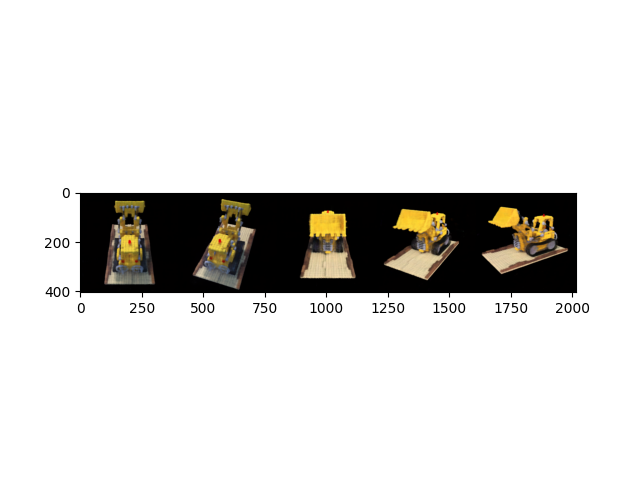

In [72]:
import cv2 
import matplotlib.pyplot as plt
%matplotlib widget
idxs = [0, 5, 50, 58, 65]

ims = []
for idx in idxs:
	path = f'results/lego/mynerf_25_imgs/rgb_{idx}.png'
	im = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
	print(im.shape)
	ims.append(im[:,403:,:])

im_big = np.hstack(ims)

print(im_big.shape)

plt.imshow(im_big)

In [ ]:
class PhaseOptic:
	def __init__(self, centers, radii, n=1.5):
		self.centers = centers
		self.radii = radii 
		self.n = n # refractive index
	
	def intersect_plane(ray):
		pass 

	def intersect_sphere(ray):
		pass
	
	def intersect(ray):
		""" Calc first intersection point and refracted ray on hitting the phase optic"""
		ro, rd = ray[:,:3], ray[:,3:]

	def get_normal(point):
		""" Gets normal vector at a point """	



		

		



In [4]:
import visu3d as v3d 

ray = v3d.Ray(pos=[0,0,0], dir=[1,1,1])




In [5]:
ray.fig